In [ ]:
!pip install pycocotools fiftyone

In [ ]:
!wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'  -O annotation.zip
!unzip '/content/annotation.zip'

In [ ]:
import fiftyone.zoo as foz
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch import nn
import torch
from PIL import Image
import cv2
import io
import numpy as np
import base64

In [ ]:
# To download the COCO dataset for only the "person" and "car" classes
dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation", "test"],
    label_types=["segmentations"],
    classes=["car"],
    max_samples=1000,
    # shuffle=True,
)

In [ ]:
dict_dataset = dataset.to_dict()
dict_dataset.keys()

 100% |███████████████| 2535/2535 [26.6s elapsed, 0s remaining, 1.2K samples/s]       


INFO:eta.core.utils: 100% |███████████████| 2535/2535 [26.6s elapsed, 0s remaining, 1.2K samples/s]       


dict_keys(['name', 'version', 'media_type', 'sample_fields', 'info', 'default_classes', 'samples'])

In [ ]:
dict_dataset["samples"][0]

In [ ]:
from pycocotools.coco import COCO

train_anns = COCO("/content/annotations/instances_train2017.json")


loading annotations into memory...
Done (t=18.40s)
creating index...
index created!


In [ ]:
np.zeros((128,128)).shape

(128, 128)

In [ ]:
class SegDataset(torch.utils.data.Dataset):

  def __init__(self, annotations, samples):
    # super(SegDataset , self)
    self.annotations = annotations
    self.image_path = []
    self.images = []
    self.image_masks= []
    for s in samples :
      resized = cv2.resize(cv2.imread(s["filepath"]), (128, 128))
      image_id = int(s["filepath"].split("/")[-1].split(".")[0])
      anns = annotations.getAnnIds(imgIds=[image_id])
      anns = annotations.loadAnns(anns)
      masks = [cv2.resize(annotations.annToMask(ann), (128,128))  for ann in anns if ann["category_id"] == 3]
      mask = np.clip(sum(masks),0, 1)
      if len(mask.shape) != 2: continue
      if len(resized.shape) != 3 : continue
      self.images.append(resized/ 255)
      self.image_path.append(s["filepath"])
      self.image_masks.append(mask)

  def __getitem__(self, idx):
    return {"image": torch.tensor(self.images[idx]), "mask": torch.tensor(self.image_masks[idx])}    

  def __len__(self,):
    return len(self.images)


torch_dataset = SegDataset(train_anns, dict_dataset["samples"])

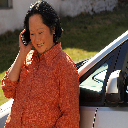

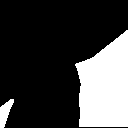

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(torch_dataset[25]["image"].numpy()*255)
cv2_imshow(torch_dataset[25]["mask"].numpy()*255)


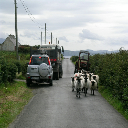

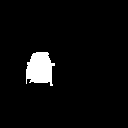

In [ ]:
cv2_imshow(torch_dataset[60]["image"].numpy()*255)
cv2_imshow(torch_dataset[60]["mask"].numpy()*255)

U-Net Model Implementation using Pytorch

In [ ]:
class U_Net(Module):
  def __init__(self):
    super(U_Net, self).__init__()
    self.encoders_in_channels = [[3, 64, 128, 256, 512], [64, 128, 256, 512, 1024]]
    self.encoders_out_channels = [64, 128, 256, 512, 1024]
    self.encoders = ModuleList()

    self.decoders_in_channels = [[1024+512, 512+256, 256+128, 128+64], [512, 256, 128, 64]]
    self.decoders_out_channels = [512, 256, 128, 64]
    self.decoders = ModuleList()
    #Encoder Blocks
    for i in range(5):
      temp = nn.Sequential(
                        nn.Conv2d(in_channels = self.encoders_in_channels[0][i], #128*128*3
                                        out_channels = self.encoders_out_channels[i], 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                        nn.ReLU(),
                        nn.Conv2d(in_channels = self.encoders_in_channels[1][i], #128*128*3
                                        out_channels=self.encoders_out_channels[i], 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                        nn.ReLU())
      # if i == 2:
      temp.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

      self.encoders.append(temp)

    self.upsample_1 = nn.Upsample(scale_factor=2)
    # Decoder Blocks
    for i in range(4):
      temp = nn.Sequential(
                        nn.Upsample(scale_factor=2), #8 --> 16
                        nn.Conv2d(in_channels = self.decoders_in_channels[0][i], 
                                        out_channels=self.decoders_out_channels[i], 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                         nn.Conv2d(in_channels = self.decoders_in_channels[1][i], 
                                        out_channels=self.decoders_out_channels[i], 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                        nn.ReLU(),)

      self.decoders.append(temp)
    

    #Output segmentation map
    self.final = nn.Conv2d(in_channels = 64, 
                                        out_channels= 1, 
                                        kernel_size = (1, 1),
                                        stride = (1, 1),
                                        padding = 1 
                                    
    )

  def encoder(self, data):
    encoded = [] 
    encoded.append(self.encoders[0](data))
    for i in range(1, len(self.encoders)):
      temp = self.encoders[i](encoded[i - 1])
      encoded.append(temp)
    return encoded

  def decoder(self, encoded, ends):
    # print(encoded[4].shape, ends[3].shape)
    x = self.upsample_1(encoded[4])
    y_1 = self.decoders[0](torch.cat((x , ends[3]), axis=1))
    # print(y_1.shape, ends[2].shape)
    y_2 = self.decoders[1](torch.cat((y_1 , ends[2]), axis=1))
    y_3 = self.decoders[2](torch.cat((y_2 , ends[1]), axis=1))
    decoded = self.decoders[3](torch.cat((y_3 , ends[0]), axis=1))
    return decoded

  def forward(self, data):   
    encoded = self.encoder(data)
    # for e in encoded:
      # print(e.shape)
    decoded = self.decoder(encoded, [encoded[0], encoded[1], encoded[2], encoded[3]])
    output = self.final(decoded)
    output = torch.sigmoid(output)
    return output

In [ ]:
# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
#         self.relu  = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
#     def forward(self, x):
#         return self.conv2(self.relu(self.conv1(x)))


# class Encoder(nn.Module):
#     def __init__(self, chs=(3,64,128,256,512,1024)):
#         super().__init__()
#         self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
#         self.pool       = nn.MaxPool2d(2)
    
#     def forward(self, x):
#         ftrs = []
#         for block in self.enc_blocks:
#             x = block(x)
#             ftrs.append(x)
#             x = self.pool(x)
#         return ftrs


# class Decoder(nn.Module):
#     def __init__(self, chs=(1024, 512, 256, 128, 64)):
#         super().__init__()
#         self.chs         = chs
#         self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
#         self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
#     def forward(self, x, encoder_features):
#         for i in range(len(self.chs)-1):
#             x        = self.upconvs[i](x)
#             enc_ftrs = self.crop(encoder_features[i], x)
#             x        = torch.cat([x, enc_ftrs], dim=1)
#             x        = self.dec_blocks[i](x)
#         return x
    
#     def crop(self, enc_ftrs, x):
#         _, _, H, W = x.shape
#         enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#         return enc_ftrs


# class UNet(nn.Module):
#     def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=1, retain_dim=True, out_sz=(128,128)):
#         super().__init__()
#         self.encoder     = Encoder(enc_chs)
#         self.decoder     = Decoder(dec_chs)
#         self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
#         self.retain_dim  = retain_dim
#         self.out_sz = out_sz
#     def forward(self, x):
#         enc_ftrs = self.encoder(x)
#         out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
#         out      = self.head(out)
#         if self.retain_dim:
#             out = F.interpolate(out, self.out_sz)
#         return out

In [ ]:
# import torchvision
# unet = UNet()
# unet(torch_dataset[0]["image"].unsqueeze(0).float().permute(0, 3,1,2)).shape

torch.Size([1, 1, 128, 128])

In [ ]:
model = U_Net()
model(torch_dataset[0]["image"].unsqueeze(0).float().permute(0, 3,1,2))


tensor([[[[0.4983, 0.4983, 0.4983,  ..., 0.4983, 0.4983, 0.4983],
          [0.4983, 0.4942, 0.4939,  ..., 0.4957, 0.4944, 0.4983],
          [0.4983, 0.4945, 0.4941,  ..., 0.4951, 0.4940, 0.4983],
          ...,
          [0.4983, 0.4946, 0.4939,  ..., 0.4930, 0.4935, 0.4983],
          [0.4983, 0.4956, 0.4954,  ..., 0.4948, 0.4945, 0.4983],
          [0.4983, 0.4983, 0.4983,  ..., 0.4983, 0.4983, 0.4983]]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
# data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=1)
# for idx, batch  in enumerate(data_loader):
#   break

In [ ]:
model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=16)
# torch.backends.cudnn.enabled = False
for e in range(10):
  for idx, batch  in enumerate(data_loader):
    
    optimizer.zero_grad()
    image = batch["image"].float().permute(0,3, 1,2).cuda()
    image_mask = batch["mask"].float().cuda()
    if len(image_mask.shape)  == 1: continue

    out = model(image)
    out = out.squeeze(1)
    out = out[:, :128, :128]
    err = torch.nn.functional.binary_cross_entropy(out, image_mask)
    err.backward()
    optimizer.step()
  print(e, err.item())
    

0 5.853618621826172
1 5.853602886199951
2 5.8535895347595215
3 5.853578090667725
4 5.853568077087402
5 5.853559494018555
6 5.853551864624023
7 5.853545665740967
8 5.85353946685791
9 5.85353422164917
